In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cellbell
import random
from sklearn.cluster import KMeans, MiniBatchKMeans
import os
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm import tqdm_notebook as tqdm
import tqdm as tq
import sys
import string
from collections import defaultdict
import itertools
import pickle
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.core.display import display, HTML
from io import BytesIO
import base64
import warnings
warnings.filterwarnings(action='once')
display(HTML("<style>.container { width:100% !important; }</style>"))
from collections import Counter

In [2]:
sns.set_context("notebook")

In [3]:
os.chdir('/Users/ianbury/Desktop/capstone2/all-the-news/articles/')
#Download: https://www.kaggle.com/snapcrack/all-the-news
dfs=[]
for file in os.listdir():
    df = pd.read_csv(file, index_col=0)
    dfs.append(df)
df = pd.concat(dfs)


In [4]:
df.head()

,id,title,publication,author,date,year,month,url,content
53293,73471,Patriots Day Is Best When It Digs Past the Her...,Atlantic,David Sims,2017-01-11,2017.0,1.0,NaN,"Patriots Day, Peter Berg’s new thriller that r..."
53294,73472,A Break in the Search for the Origin of Comple...,Atlantic,Ed Yong,2017-01-11,2017.0,1.0,NaN,"In Norse mythology, humans and our world were ..."
53295,73474,Obama’s Ingenious Mention of Atticus Finch,Atlantic,Spencer Kornhaber,2017-01-11,2017.0,1.0,NaN,“If our democracy is to work in this increasin...
53296,73475,"Donald Trump Meets, and Assails, the Press",Atlantic,David A. Graham,2017-01-11,2017.0,1.0,NaN,Updated on January 11 at 5:05 p. m. In his fir...
53297,73476,Trump: ’I Think’ Hacking Was Russian,Atlantic,Kaveh Waddell,2017-01-11,2017.0,1.0,NaN,Updated at 12:25 p. m. After months of equivoc...


In [5]:
df['date'] = pd.to_datetime(df['date']).dt.date
df.set_index('id',inplace=True)

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ianbury/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ianbury/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ianbury/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# EDA

In [7]:
#Applying anecdotal political bias rankings - based on consensus of online research
df['publication'] = pd.Categorical(df['publication'],['Buzzfeed News','Vox','Talking Points Memo','Atlantic','CNN','Washington Post','Guardian','Business Insider','New York Times','NPR','Reuters','National Review', 'New York Post','Fox News','Breitbart'])

In [8]:
by_source=df.groupby('publication').agg({'title':'count','author':'nunique'}).reset_index()
by_source_date = df.dropna(subset=['date']).groupby('publication').agg({'date':['min','max']}).reset_index()
by_source=by_source.merge(by_source_date, on='publication')
by_source

/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:543: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3108: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,publication,title,author,"(date, min)","(date, max)"
0,Buzzfeed News,4854,345,2016-01-02,2017-06-24
1,Vox,4947,356,2014-04-19,2017-04-30
2,Talking Points Memo,5213,121,2003-06-14,2017-06-19
3,Atlantic,7179,708,2016-01-03,2017-06-06
4,CNN,11488,527,2011-11-22,2017-06-21
5,Washington Post,11114,1563,2011-09-08,2017-07-06
6,Guardian,8681,1379,2009-03-25,2017-07-01
7,Business Insider,6757,184,2016-01-01,2017-06-20
8,New York Times,7803,2430,2014-05-08,2017-06-19
9,NPR,11992,1178,2000-05-15,2017-06-29


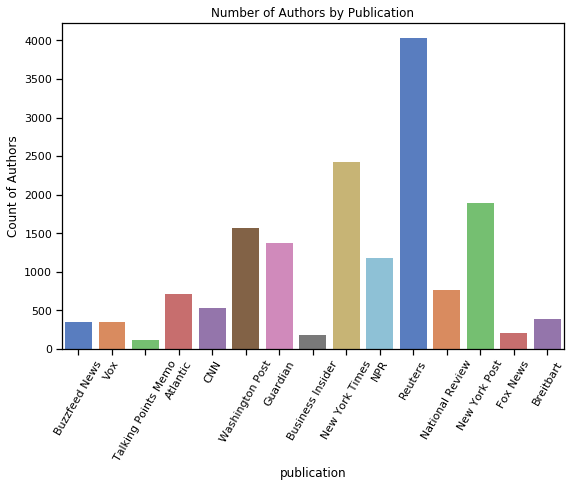

In [9]:
fig=plt.figure(figsize=(9,6))
_=sns.barplot(x='publication',data=by_source,y='author',palette='muted')
_=plt.ylabel('Count of Authors')
_=plt.xticks(rotation=60)
_=plt.title('Number of Authors by Publication')


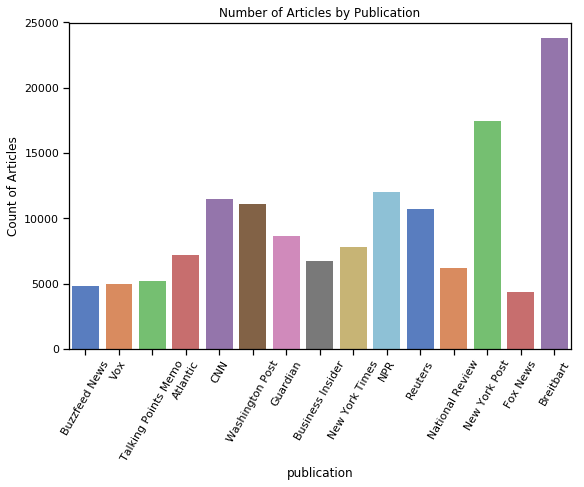

In [10]:
fig=plt.figure(figsize=(9,6))
_=sns.barplot(x='publication',data=by_source,y='title',palette='muted')
_=plt.ylabel('Count of Articles')
_=plt.xticks(rotation=60)
_=plt.title('Number of Articles by Publication')

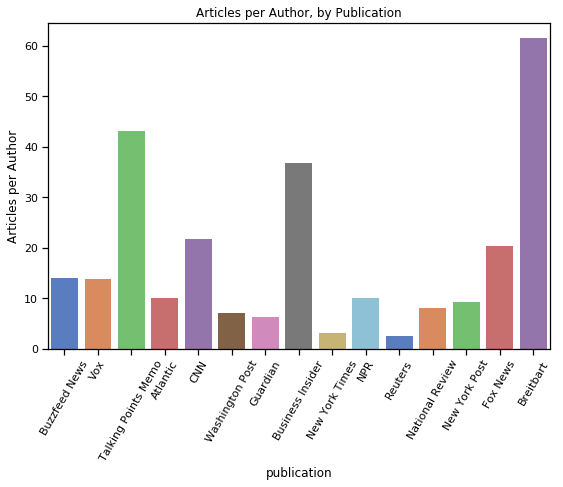

In [11]:
by_source['articles_per_author'] = by_source['title'] / by_source['author']
fig=plt.figure(figsize=(9,6))
_=sns.barplot(x='publication',data=by_source,y='articles_per_author',palette='muted')
_=plt.ylabel('Articles per Author')
_=plt.xticks(rotation=60)
_=plt.title('Articles per Author, by Publication')

In [12]:
df['length'] = df.content.apply(lambda x: len(nltk.word_tokenize(x)))

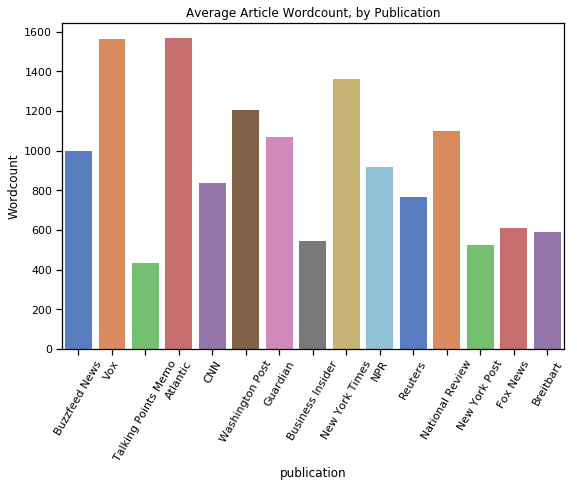

In [13]:
length = df.groupby(['publication'])['length'].mean().reset_index()
fig=plt.figure(figsize=(9,6))
_=sns.barplot(x='publication',data=length,y='length',palette='muted')
_=plt.ylabel('Wordcount')
_=plt.xticks(rotation=60)
_=plt.title('Average Article Wordcount, by Publication')

# Pre-processing

In [14]:
def clean(raw):
    """
    Function to clean text to keep only letters and remove stopwords
    Returns a string of the cleaned raw text
    """
    letters_only = re.sub('[^a-zA-Z]', ' ', raw)
    words = letters_only.lower().split()
    stopwords_eng = set(nltk.corpus.stopwords.words("english"))
    useful_words = [x for x in words if not x in stopwords_eng]
    
    # Combine words into a paragraph again
    useful_words_string = ' '.join(useful_words)
    return(useful_words_string)

In [15]:
#Apply cleaning to article content
df['clean'] = df['content'].apply(clean)

/anaconda3/lib/python3.6/site-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/ianbury/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [16]:
#Creating all-in-one token-lemmatizer to pass into the tfidf vectorizer
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemm_words(words_list, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words_list]
    
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    lemmas = lemm_words(tokens, lemmatizer)
    return lemmas

In [17]:
#Apply lemmatization and tokenize the "cleaned" text
#Create Tf-idf vector matrix from tokens

#stemmer = PorterStemmer()

#def stem_words(words_list, stemmer):
    #return [stemmer.stem(word) for word in words_list]


tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
tfs = tfidf.fit_transform(tqdm(df.clean.values))


/anaconda3/lib/python3.6/site-packages/nltk/corpus/reader/wordnet.py:1107: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/ianbury/nltk_data/corpora/wordnet/lexnames'>
  for i, line in enumerate(self.open('lexnames')):
/anaconda3/lib/python3.6/site-packages/nltk/corpus/reader/wordnet.py:1159: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/ianbury/nltk_data/corpora/wordnet/index.adj'>
  for i, line in enumerate(self.open('index.%s' % suffix)):
/anaconda3/lib/python3.6/site-packages/nltk/corpus/reader/wordnet.py:1159: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/ianbury/nltk_data/corpora/wordnet/index.adv'>
  for i, line in enumerate(self.open('index.%s' % suffix)):
/anaconda3/lib/python3.6/site-packages/nltk/corpus/reader/wordnet.py:1159: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/ianbury/nltk_data/corpora/wordnet/index.noun'>
  for i, line in enumerate(self.open('index.%s' % suffix)):
/anaconda3/lib/python3.6/site

In [18]:
#trained vectorizer
#filename = '/Users/ianbury/Desktop/capstone2/vectorizer.pkl'
#pickle.dump(tfidf,open(filename,'wb'))

In [19]:
#Checkpoint tfs
#filename = '/Users/ianbury/Desktop/capstone2/tfs_lemma.pkl'
#pickle.dump(tfs,open(filename,'wb'))

In [20]:
#Checkpoint for already processed tf-idfs

#with open('/Users/ianbury/Desktop/capstone2/tfs_lemma.pkl','rb') as f:
#    tfs=pickle.load(f)

# Dimensionality Reduction

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix


In [22]:
tsvd = TruncatedSVD(n_components=1000)
X_sparse_tsvd = tsvd.fit(tfs).transform(tfs)

In [23]:
print('Original number of features:', tfs.shape[1])
print('Reduced number of features:', X_sparse_tsvd.shape[1])

Original number of features: 273976
Reduced number of features: 1000


In [24]:
tsvd.explained_variance_ratio_[0:3].sum()


0.020731207086131388

# Topic Modeling - KMeans

In [25]:
km = KMeans(n_clusters=50, max_iter=30, n_init=5, init='k-means++', tol=1)
km.fit(tfs)
filename = '/Users/ianbury/Desktop/capstone2/km_model_50.sav'
#pickle.dump(km,open(filename,'wb'))
km.inertia_

129413.70050972713

In [ ]:
#with open('/Users/ianbury/Desktop/capstone2/km_model_50.sav','rb') as f:
#    km=pickle.load(f)

In [26]:
km.inertia_

129413.70050972713

# Topic Modeling - MiniBatch Kmeans

In [27]:
def save_as_pickled_object(obj, filepath):
    """
    This is a defensive way to write pickle.write, allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    bytes_out = pickle.dumps(obj,protocol=4)
    n_bytes = sys.getsizeof(bytes_out)
    with open(filepath, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])


def try_to_load_as_pickled_object_or_None(filepath):
    """
    This is a defensive way to write pickle.load, allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    try:
        input_size = os.path.getsize(filepath)
        bytes_in = bytearray(0)
        with open(filepath, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        obj = pickle.loads(bytes_in)
    except:
        return None
    return obj

In [28]:
inertias=[]
for k in tqdm([50,500,800,1000,1200,5000]):    
    km = MiniBatchKMeans(n_clusters=k, max_iter=30, init='random',  init_size=30000)
    km.fit(tfs)
    filename = '/Users/ianbury/Desktop/capstone2/km_model_mb_{}.sav'.format(k)
    #pickle.dump(km,open(filename,'wb'))
    #save_as_pickled_object(km,filename)
    inertias.append(km.inertia_)

In [29]:
#km50 = try_to_load_as_pickled_object_or_None('/Users/ianbury/Desktop/capstone2/km_model_mb_50.sav')
#km500 = try_to_load_as_pickled_object_or_None('/Users/ianbury/Desktop/capstone2/km_model_mb_500.sav')
#km800 = try_to_load_as_pickled_object_or_None('/Users/ianbury/Desktop/capstone2/km_model_mb_800.sav')
km1000 = try_to_load_as_pickled_object_or_None('/Users/ianbury/Desktop/capstone2/km_model_mb_1000.sav')
#km1200 = try_to_load_as_pickled_object_or_None('/Users/ianbury/Desktop/capstone2/km_model_mb_1200.sav')
#km5000 = try_to_load_as_pickled_object_or_None('/Users/ianbury/Desktop/capstone2/km_model_mb_5000.sav')


/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator MiniBatchKMeans from version 0.20.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [30]:
km_standard = try_to_load_as_pickled_object_or_None('/Users/ianbury/Desktop/capstone2/km_model_50.sav')

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator KMeans from version 0.20.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [31]:
#inertias = [km.inertia_ for km in [km50, km500,km800, km1000, km1200, km5000]]

In [32]:
inertias

[132898.0956409146,
 123486.39480454475,
 121750.02823373873,
 114935.18362667674,
 118252.69858093388,
 122039.68201066414]

In [33]:
inertias_x = [50,500,800,1000,1200,5000]

Text(0.5,1,'Inertia of MiniBatch KMeans vs. KMeans(k=50)')

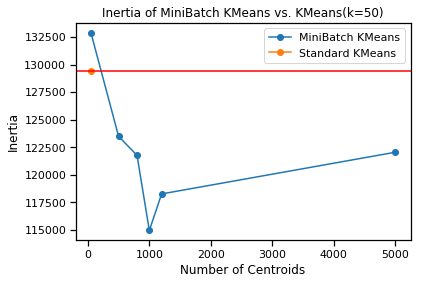

In [34]:
plt.plot(inertias_x,inertias,label='MiniBatch KMeans', marker='o')
plt.plot(50,km_standard.inertia_, label='Standard KMeans',marker='o')
plt.axhline(km_standard.inertia_,c='red')
plt.xlabel('Number of Centroids')
plt.ylabel('Inertia')
plt.legend()
plt.title('Inertia of MiniBatch KMeans vs. KMeans(k=50)')

k=1000 minimizes inertia for MiniBatch KMeans. This model trains in under an hour, versus normal KMeans, which failed to train after 24 hours.

# Topic Modeling - HDBSCAN
One of the drawbacks for using KMeans is determining in advance the number of clusters. Given this is unknown for the set of ~140k articles and that tuning this parameter has a very long interation time (3 hrs), I've also used HDBSCAN in which the only parameter to define in the minimum cluster size. 

In [ ]:
#Fitting HDSCAN model to TF-IDFs to determine topics

hd = hdbscan.HDBSCAN(min_cluster_size=10)
hd.fit(tfs)
with open('hdbscan_fitted.pkl','wb') as f:
    pickle.dump(clusterer,f)
    
#This cell fails, even on large memory-optimized ec2 nodes, due to the size of the dataset. Leaving this in the notebook for use with smaller datasets.

In [ ]:
#trying with a different, more efficient algorithm. Still fails.

dense_tfs = tfs.todense()
hd = hdbscan.HDBSCAN(min_cluster_size=30,algorithm='boruvka_kdtree',core_dist_n_jobs=3)
hd.fit(dense_tfs)

# Sentiment Analysis

In [36]:
#adding MPQA sentiment corpus to VaderSentiment corpus
#https://mpqa.cs.pitt.edu/
with open('/Users/ianbury/Downloads/mpqa_features.pickle','rb') as f:
    mpqa=pickle.load(f, encoding='latin1')
new_words = mpqa.groupby('word_').c_pol.mean().reset_index()
nw={}
for val in new_words.iterrows():
    nw[val[1][0]]=val[1][1]

In [37]:
analyser = SentimentIntensityAnalyzer()
analyser.lexicon.update(nw)

In [38]:
def sent_to_frame(df):
    """
    Initially returns a sentiment analysis matrix for inputted content,
    then merges sentiment scores as columns back to the original dataframe
    """
    neg=[]
    neu=[]
    pos=[]
    comp=[]
    for k in tqdm(list(df)):
        snt = analyser.polarity_scores(k)
        neg.append(snt['neg'])
        neu.append(snt['neu'])
        pos.append(snt['pos'])
        comp.append(snt['compound'])
    df_sub=pd.DataFrame({'neg':neg,'neu':neu,'pos':pos,'comp':comp})
    return df_sub

In [40]:

df_sub = sent_to_frame(df.content.astype(str))


In [41]:
cols=df.columns.append(df_sub.columns)
df = pd.DataFrame(np.hstack([df,df_sub]),columns=cols)

In [42]:
#storing main df to avoid re-running sentiment analysis operation
#with open('df_sentiment.pkl','wb') as f:
#    pickle.dump(df,f)

In [45]:
full_df = df #ugly copy to retrofit checkpoint and run from scratch
#with open('/Users/ianbury/Desktop/capstone2/df_sentiment.pkl','rb') as f:
#    full_df=pickle.load(f)

In [46]:
full_df.merge(df[['title','length']],how='left', on='title')

,title,publication,author,date,year,month,url,content,length_x,clean,neg,neu,pos,comp,length_y
0,Patriots Day Is Best When It Digs Past the Her...,Atlantic,David Sims,2017-01-11,2017,1,NaN,"Patriots Day, Peter Berg’s new thriller that r...",1047,patriots day peter berg new thriller recreates...,0.193,0.712,0.095,-0.9982,1047
1,A Break in the Search for the Origin of Comple...,Atlantic,Ed Yong,2017-01-11,2017,1,NaN,"In Norse mythology, humans and our world were ...",1602,norse mythology humans world created pantheon ...,0.096,0.842,0.062,-0.9913,1602
2,Obama’s Ingenious Mention of Atticus Finch,Atlantic,Spencer Kornhaber,2017-01-11,2017,1,NaN,“If our democracy is to work in this increasin...,1028,democracy work increasingly diverse nation bar...,0.194,0.723,0.083,-0.9983,1028
3,"Donald Trump Meets, and Assails, the Press",Atlantic,David A. Graham,2017-01-11,2017,1,NaN,Updated on January 11 at 5:05 p. m. In his fir...,1148,updated january p first press conference since...,0.153,0.741,0.105,-0.99,1148
4,Trump: ’I Think’ Hacking Was Russian,Atlantic,Kaveh Waddell,2017-01-11,2017,1,NaN,Updated at 12:25 p. m. After months of equivoc...,476,updated p months equivocating origin cyberatta...,0.088,0.863,0.049,-0.8709,476
5,Seth Meyers Questions Kellyanne Conway (and th...,Atlantic,Megan Garber,2017-01-11,2017,1,NaN,Here was one of the first questions that Seth ...,1331,one first questions seth meyers comedian posed...,0.108,0.803,0.089,-0.6258,1331
6,Obama Frames His Economic Legacy,Atlantic,Gillian B. White,2017-01-11,2017,1,NaN,"In Barack Obama’s final speech as president, h...",959,barack obama final speech president touted nea...,0.188,0.701,0.111,-0.9945,959
7,The Trump Administration’s Conflicts of Intere...,Atlantic,Jeremy Venook,2017-01-11,2017,1,NaN,"With confirmation hearings beginning, attentio...",3836,confirmation hearings beginning attention shif...,0.14,0.795,0.065,-0.9997,3836
8,The Longstanding Crisis Facing Tribal Schools,Atlantic,Alia Wong,2017-01-12,2017,1,NaN,"Havasu Canyon is home to turquoise waterfalls,...",1171,havasu canyon home turquoise waterfalls billow...,0.12,0.853,0.027,-0.9973,1171
9,The Atlantic Daily: Loose Ends and Legacy,Atlantic,Rosa Inocencio Smith,2017-01-12,2017,1,NaN,This article is part of a feature we a...,1406,article part feature also send via email atlan...,0.095,0.856,0.049,-0.9886,1406


In [47]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142570 entries, 0 to 142569
Data columns (total 14 columns):
title          142568 non-null object
publication    142570 non-null object
author         126694 non-null object
date           139929 non-null object
year           139929 non-null object
month          139929 non-null object
url            85559 non-null object
content        142570 non-null object
length         142570 non-null object
clean          142570 non-null object
neg            142570 non-null object
neu            142570 non-null object
pos            142570 non-null object
comp           142570 non-null object
dtypes: object(14)
memory usage: 15.2+ MB


In [48]:
#Sentiment analysis on title
full_df['title'] = full_df['title'].str.replace(' - The New York Times','')
sentiment_title = sent_to_frame(full_df.title.astype(str))
sentiment_title.columns = [a+'_title' for a in sentiment_title.columns]
cols=full_df.columns.append(sentiment_title.columns)
full_df = pd.DataFrame(np.hstack([full_df,sentiment_title]),columns=cols)

In [49]:

for col in ['neg','neu','pos','comp','neg_title','pos_title','neu_title','comp_title']:
    full_df[col]=full_df[col].astype(float)
full_df['sentiment_diff'] = (abs(full_df['comp'])-abs(full_df['comp_title'])).astype(float)

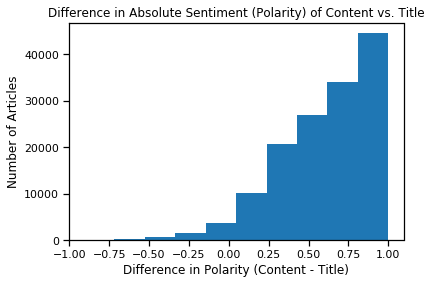

In [50]:
_=plt.title('Difference in Absolute Sentiment (Polarity) of Content vs. Title')
_=plt.hist(full_df.sentiment_diff)
_=plt.xlabel('Difference in Polarity (Content - Title)')
_= plt.ylabel('Number of Articles')

In [51]:
print('Average difference between sentiment of content vs. title: {}'.format(round(full_df.sentiment_diff.median(),3)))
#Article content tends to be much more polar than the article title.

Average difference between sentiment of content vs. title: 0.656


# Merging Cluster numbers (e.g. topic_id) to main df

In [52]:
#Applying labels from fitted model back to original dataFrame.
def add_labels(df_input,clf):
    """
    Takes a dataframe and trained clustering model as inputs,
    returns the original dataframe with the cluster labels from the model
    as a new column 'topic_id'
    """
    cluster_assignments_dict = {}
    clean_dict=df_input['clean'].to_dict()

    for i in tqdm(set(clf.labels_)):
        current_cluster = [list(clean_dict.keys())[x] for x in np.where(clf.labels_ == i)[0]]
        cluster_assignments_dict[i] = current_cluster

    inverted_cluster_dict={}
    for k, v in cluster_assignments_dict.items():
        for x in v:
            inverted_cluster_dict[x]=k
    df_input['topic_id'] = pd.Series(inverted_cluster_dict)
    return df_input

In [53]:
full_df = add_labels(full_df,km1000)

# LDA - determine topic keywords

In [54]:
full_df['title_clean'] = full_df['title'].astype(str).apply(clean)

/anaconda3/lib/python3.6/site-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/ianbury/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [55]:
topic_dict={}
for t in tqdm(full_df.topic_id.unique()):
    count = CountVectorizer(stop_words='english',tokenizer=tokenize, max_features = 5000)
    X = count.fit_transform(full_df[full_df.topic_id==t]['title_clean'].values)
    lda = LatentDirichletAllocation(n_components=1, learning_method='online')
    X_topics = lda.fit_transform(X)
    feature_names = count.get_feature_names()
    topic_dict[t] = ' '.join([feature_names[i] for i in lda.components_.ravel().argsort()[:-6:-1]])

In [56]:
full_df['topic_text'] = full_df.topic_id.apply(lambda x: topic_dict[x])

In [57]:
#Most common keywords across all 1000 topics
tokens = nltk.word_tokenize(' '.join(list(topic_dict.values())))
c = Counter(tokens)
c.most_common(20)

[('trump', 834),
 ('breitbart', 635),
 ('u', 398),
 ('clinton', 306),
 ('new', 281),
 ('say', 207),
 ('donald', 178),
 ('obama', 111),
 ('hillary', 76),
 ('year', 55),
 ('woman', 36),
 ('day', 29),
 ('house', 29),
 ('state', 26),
 ('time', 23),
 ('republican', 22),
 ('attack', 21),
 ('world', 21),
 ('american', 20),
 ('gop', 20)]

Clearly, the most popular topics of the last several years are related to presidential politics, Russia, and the police. In future iterations, adding bi-grams would combine 'hillary' and 'clinton' or 'trump' and 'donald' to clean up these topic keywords.

# Subjectivity

In [58]:
#Anecdotal bias ordering - Buzzfeed == far left, Breitbart == far right
full_df['publication'] = pd.Categorical(full_df['publication'],['Buzzfeed News','Vox','Talking Points Memo','Atlantic','CNN','Washington Post','Guardian','Business Insider','New York Times','NPR','Reuters','National Review', 'New York Post','Fox News','Breitbart'])

In [59]:
# The subjectivity of a news articles is equivalent to the inverse of its 'neutral' score. That is, if 'neutral' == 1, the article is completely objective (~subjective).
full_df['subjectivity_content'] = full_df['neu'].apply(lambda x: 1-x)
full_df['subjectivity_title'] = full_df['neu_title'].apply(lambda x: 1-x)

In [60]:
avg_subj = full_df.groupby('publication')['subjectivity_content','subjectivity_title'].agg('mean').reset_index()

In [61]:
avg_subj=avg_subj.melt(id_vars='publication',value_vars=['subjectivity_content','subjectivity_title'], value_name='subjectivity',var_name='type')

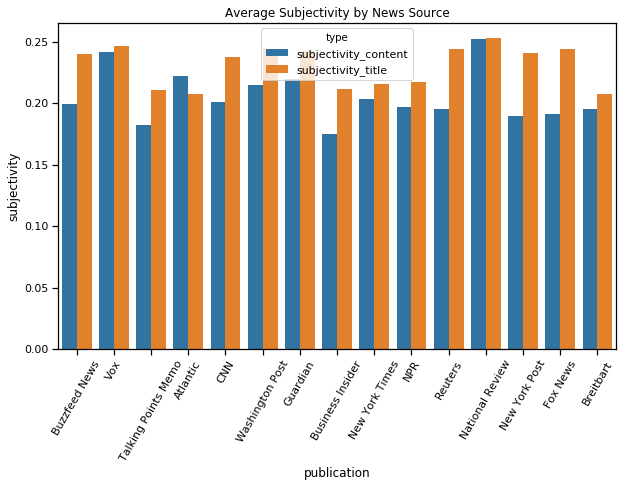

In [62]:
#Is there a substantial difference in subjectivity of article title vs. article content?
fig = plt.figure(figsize=(10,6))
_=sns.barplot(data=avg_subj, x='publication', y='subjectivity', hue='type' )
_=plt.xticks(rotation=60)
_=plt.title('Average Subjectivity by News Source')

In [63]:
avg_subj[avg_subj['type']=='subjectivity_content'].sort_values('subjectivity',ascending=True)

,publication,type,subjectivity
7,Business Insider,subjectivity_content,0.174906
2,Talking Points Memo,subjectivity_content,0.181867
12,New York Post,subjectivity_content,0.189368
13,Fox News,subjectivity_content,0.191330
10,Reuters,subjectivity_content,0.195426
14,Breitbart,subjectivity_content,0.195487
9,NPR,subjectivity_content,0.196697
0,Buzzfeed News,subjectivity_content,0.199341
4,CNN,subjectivity_content,0.200710
8,New York Times,subjectivity_content,0.203337


# Post-processing EDA

In [65]:
topics=full_df[['topic_id','topic_text']].drop_duplicates()
topics['topic_id']=topics['topic_id'].astype(int)

In [66]:
by_topic = full_df.groupby(['publication','topic_id'])

,title,publication,author,date,year,month,url,content,length,clean,...,neg_title,neu_title,pos_title,comp_title,sentiment_diff,topic_id,title_clean,topic_text,subjectivity_content,subjectivity_title
0,Patriots Day Is Best When It Digs Past the Her...,Atlantic,David Sims,2017-01-11,2017,1,NaN,"Patriots Day, Peter Berg’s new thriller that r...",1047,patriots day peter berg new thriller recreates...,...,0.000,0.596,0.404,0.6632,0.3350,664,patriots day best digs past heroism,trump plan year breitbart say,0.288,0.404
1,A Break in the Search for the Origin of Comple...,Atlantic,Ed Yong,2017-01-11,2017,1,NaN,"In Norse mythology, humans and our world were ...",1602,norse mythology humans world created pantheon ...,...,0.281,0.719,0.000,-0.2789,0.7124,272,break search origin complex life,trump breitbart say u clinton,0.158,0.281
2,Obama’s Ingenious Mention of Atticus Finch,Atlantic,Spencer Kornhaber,2017-01-11,2017,1,NaN,“If our democracy is to work in this increasin...,1028,democracy work increasingly diverse nation bar...,...,0.000,1.000,0.000,0.0000,0.9983,151,obama ingenious mention atticus finch,trump atlantic daily new donald,0.277,0.000
3,"Donald Trump Meets, and Assails, the Press",Atlantic,David A. Graham,2017-01-11,2017,1,NaN,Updated on January 11 at 5:05 p. m. In his fir...,1148,updated january p first press conference since...,...,0.000,0.774,0.226,0.1901,0.7999,622,donald trump meets assails press,trump breitbart new u clinton,0.259,0.226
4,Trump: ’I Think’ Hacking Was Russian,Atlantic,Kaveh Waddell,2017-01-11,2017,1,NaN,Updated at 12:25 p. m. After months of equivoc...,476,updated p months equivocating origin cyberatta...,...,0.000,1.000,0.000,0.0000,0.8709,436,trump think hacking russian,trump u breitbart north korea,0.137,0.000


In [64]:

by_topic=by_topic.merge(topics, how='left', on='topic_id')

NameError: name 'by_topic' is not defined

In [ ]:
#Random sample of sentiment by publication for given topics.
#Sources are orderd on the x-axis, with traditional left-wing sources on the left, right on the right.
fig = plt.subplots(3,3,figsize=(24, 18))
p=0
for n in random.sample(range(0,1000), 9):
    _ = plt.subplot(3,3,p+1)
    t= by_topic[by_topic.topic_id==n]
    _=sns.barplot(x='publication',data=t,y='comp_title',palette='muted')
    _=plt.ylabel('Average Sentiment')
    _=plt.xticks(rotation=60)
    #_=plt.suptitle('Sentiment by Publication, Topic')
    _=plt.title('Topic: {}'.format(t.topic_text.unique()[0]))
    p+=1

plt.tight_layout() 

In [ ]:
#with open('full_df.pkl','wb') as f:
#pickle.dump(full_df,f)

In [ ]:
#with open('/Users/ianbury/Desktop/capstone2/full_df.pkl','rb') as f:
#    full_df=pickle.load(f)

In [ ]:
plt.subplots(2,2,figsize=(18,13))
_=plt.suptitle('Distribution of Articles per Topic')
d=full_df.groupby('topic_id').title.count().reset_index()['title']
sns.set_style('whitegrid')
plt.subplot(2,2,1)
_=sns.violinplot(d, orient='h',inner='quartile',color='lightblue',cut=0)
_=plt.xlabel('Number of Articles, per topic',size=13)
plt.subplot(2,2,3)
_=sns.violinplot(d, orient='h',inner='quartile',color='lightblue',cut=0)
_=plt.xlabel('Number of Articles, per topic',size=13)
_=plt.xlim((-100,1000))
_=plt.xticks(np.arange(-100, 1000, 50),rotation=30)


plt.subplot(2,2,2)
_=sns.distplot(d, kde_kws={'cumulative':True})
_=plt.xlabel('Number of Articles, per topic',size=13)

plt.subplot(2,2,4)
b_width = 50  # chose an arbitrary value here
my_bins = np.arange(min(d), max(d) + b_width, b_width)
_=sns.distplot(d,bins=my_bins, kde_kws={'cumulative':False})
_=plt.xlabel('Number of Articles, per topic',size=13)
_=plt.xlim((-100,1000))
_=plt.xticks(np.arange(-100, 1000, 50),rotation=30)


In [ ]:
d.describe()

In [ ]:
#Randomly select article plotted against the median subjecivity/sentiment from other news sources on the same topic.
#Essentially, where does this sample article fit vs. the rest of the population?
samp = full_df.sample(1)
tid=samp['topic_id'].values[0]
x=samp['subjectivity_content'].values[0]
y=samp['comp'].values[0]


data = full_df[full_df.topic_id==tid].groupby('publication')[['comp','subjectivity_content']].median().reset_index().append(pd.DataFrame({'publication':'Your Article','comp':[y],
                         'subjectivity_content':[x]}))
markers = {}
for n,a in enumerate(data.publication.values):
    markers[a] = "." if n<10 else "*"
fig=plt.figure(figsize=(8,6))
sns.set_palette('deep',n_colors=16)
_=sns.scatterplot(data=data,x='subjectivity_content',y='comp', hue='publication',palette='deep', legend='full',style='publication', s=200, markers=markers)
ax=plt.gca()
ax.annotate('Your Article',(x,y))
_=ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
_=plt.xlabel('Topic Subjectivity')
_=plt.ylabel('Topic Sentiment')
_=plt.title('Median Sentiment, Subjectivity by Source on this Topic')
figfile = BytesIO()
plt.savefig(figfile, format='png',pad_inches=2)
figfile.seek(0)  # rewind to beginning of file
figdata_png = base64.b64encode(figfile.getvalue())


In [ ]:
#Distribution of subjectivity
fig=plt.figure(figsize=(9,6))
_=sns.kdeplot(full_df.subjectivity_content,shade=True,legend=False)
_=plt.xlabel('Subjectivity Score')
_=plt.ylabel('Distribution')
#Fairly symmetrical distribution centered around 'slightly subjective', some clear outliers.

In [ ]:
#Distribution of Sentiment
fig=plt.figure(figsize=(9,6))
_=sns.kdeplot(full_df.comp,shade=True,legend=False)
_=plt.xlabel('Sentiment Score')
_=plt.ylabel('Distribution')
#Bimodal, with concentration at polar scores, significant skew towards negative articles.

In [ ]:
#Are some publications noticeably more subjective than others, on average? Surprisingly, no.
dt = full_df.groupby('publication').mean().reset_index()
fig=plt.figure(figsize=(9,6))
sns.barplot(data=dt, x='publication', y='subjectivity_content')
_=plt.ylabel('Median Subjectivity Score')
_=plt.xticks(rotation=60)
_=plt.title('Subjectivity by Publication')

In [ ]:
#Adding in the anecdotal bias rankings from prior research. 
#This will be used in the plot below to visualize how those rankings match against measured subjectivity, sentiment.
dt['obj_rank'] = pd.Series(np.array([4,4,4,3,3,3,2,2,2,1,1,2,2,3,4]))

In [ ]:
#Another look at average subjectivity/sentiment by publication. 
#Bubble size indicates anecdotal bias rank, as determined by sites like (https://www.marketwatch.com/story/how-biased-is-your-news-source-you-probably-wont-agree-with-this-chart-2018-02-28).
#Larger bubbles indicate higher bias.
fig=plt.figure(figsize=(8,6))

#markers = {}
#for n,a in enumerate(dt.publication.values):
#    markers[a] = "." if n<10 else "*"

sc=sns.scatterplot(data=dt,x='subjectivity_content',y='comp', hue='publication', legend='full', s=dt['obj_rank']*150,alpha=0.7)#, style='publication')#,markers=markers)
_=plt.xlabel('Average Subjectivity')
_=plt.ylabel('Average Sentiment')
_=plt.title('Aggregate Sentiment & Subjectivity by Publication')
ax=plt.gca()
_=ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0,fontsize='small')


# Over Time

In [ ]:
#Classify articles as positive or negative
full_df['is_pos']=full_df['comp'].apply(lambda x: 1 if x > 0 else (0 if x < 0 else np.nan))

In [ ]:
#Get proportion of positive articles by year
pos_year= full_df.groupby(['year', 'is_pos'])['title'].count().reset_index()

In [ ]:
total_year = pos_year.groupby('year')['title'].sum().reset_index()
pos_year=pos_year.merge(total_year, on='year')

In [ ]:
pos_year['pct_pos'] = pos_year['title_x']/pos_year['title_y']
pos_year.year=pos_year.year.astype(int)

In [ ]:
#Is the proportion of negative articles increasing over time?
_=sns.barplot(data=pos_year[(pos_year.is_pos==1)&(pos_year.year>=2013)], x='year',y='pct_pos')
_=plt.title('Percent of Positive Articles over time')
_=plt.ylabel('% of articles with positive sentiment')
_=plt.xlabel('Year')
#It appears so. Years prior to 2013 were dropped due to very small sample size.

In [ ]:
#Aggregate subjectivity by year
subj_year= full_df.groupby('year')['subjectivity_content'].mean().reset_index()
subj_year.year=subj_year.year.astype(int)

In [ ]:
#Is the average article becoming more subjective?
_=sns.barplot(data=subj_year[(subj_year.year>=2013)], x='year',y='subjectivity_content')
_=plt.title('Average Subjectivity by Year')
_=plt.ylabel('Subjectivity Score')
_=plt.xlabel('Year')
#Not really, small variation year to year.